In [1]:
from __future__ import division # always-float division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import glob
import pprint
import os
import cv2
import re

# !pip install pygal_maps_fr
from pygal_maps_fr.maps import Departments as mapDeps
import pygal
from IPython.display import SVG, display

# Set some pretty-printing options
np.set_printoptions(precision=3, suppress=True, linewidth=120)
pd.set_option('float_format', lambda x: '%.3g' % x, )
%matplotlib inline

## Model classes

In [76]:
class Country:
    def __init__(self, n=1, k=1):
        self.n = n
        self.k = k
        self.C_S = np.zeros((n,n))
        self.C_E = np.zeros((n,n))
        self.C_I = np.zeros((n,n))
        self.C_R = np.zeros((n,n))
        self.regions = []
        self.workSectors = []
        self.lam = np.zeros(n)
        self.beta = np.zeros(n)
        self.alpha0 = 0.0
        self.sigma = 0.0
        self.d_E = 0.0
        self.gamma = 0.0
        
    def idx_region(self, name):
        for i in range(len(self.regions)):
            r = self.regions[i]
            if r.name == name:
                return i
        return -1
    
    def seed(self, name, n, target, source='S'):
        idx = self.idx_region(name)
        assert idx != -1, "Name not valid"
        
        self.regions[idx].seed(n, target, source=source)
        
        
    
    def load_regions(self, regs):
        assert len(regs) == self.n, "Region dictionary has different size than country region number"
        self.regions = []
        for name, pop in regs.items():
            self.regions.append(Region(name, N=pop))
            
    def set_params(self, params):
        assert len(params) == 4, "Parameter length must be equal to 4"
        self.d_E, self.gamma, self.alpha0, self.sigma = params
        
    def set_mobility(self, mobilities):
        assert len(mobilities) == 4 or len(mobilities) == self.n, "Bad mobility matrix dimension"
        
        if len(mobilities) == self.n:
            self.C_S = mobilities
            self.C_E = mobilities
            self.C_I = mobilities
            self.C_R = mobilities
        else:
            self.C_S = mobilities[0]
            self.C_E = mobilities[1]
            self.C_I = mobilities[2]
            self.C_R = mobilities[3]
    
    def set_transmission(self, beta):
        if isinstance(beta, float):
            self.beta.fill(beta)
        else:
            assert len(beta) == self.n, "Bad transmission vector dimension"
            self.beta = beta
            
        
    def updateForceInfection(self, overwrite=True):
        FOI = np.zeros(self.n)
        mobilites = [self.C_S, self.C_E, self.C_I, self.C_R]
        for i in range(self.n):
            lam_i = 0.0
            for j in range(self.n):
                num = 0.0
                den = 0.0
                for k in range(self.n):
                    num += self.beta[i] * self.C_I[k, j] * self.regions[k].status[2]
                    for x in range(4):
                        den += mobilites[x][k, j] * self.regions[k].status[x]
                lam_i += self.C_S[i, j] * num / den 
            FOI[i] = lam_i
        if overwrite:
            self.lam = FOI
        return FOI
    
    def alpha(self, sigma):
        num = 0.0
        den = 1.0
        for w in self.workSectors:
            num += (1 - int(w.isEssential())) * (1 - int(w.isWorking())) * w.workers * (1 - w.s)
            den += w.workers
        return self.alpha0 * (1 + sigma * num/den)

    def summary(self):
        return sum([x.status for x in self.regions])

    def set_status(self, status):
        assert len(status) == 1 or len(status) == len(self.regions), "Not correct status shape"
        
        if len(status) == 1:
            for r in self.regions:
                r.set_status(status[0])
        else:
            for i in range(len(status)):
                self.regions[i].set_status(status[i])
    
    def step(self, beta=None, full=True):
        
        if beta != None:
            self.set_transmission(beta)
        
        self.updateForceInfection()
        alpha = self.alpha(self.sigma)
        
        new_stat = []
        
        for i in range(len(self.regions)):
            lam_i = self.lam[i]
#             print(lam_i)
            reg_i = self.regions[i]
            params_i = [lam_i, self.d_E, self.gamma, alpha]
            new_stat.append(reg_i.step(params_i))
        
        if full:
            return new_stat
        else:
            return sum(new_stat)
    
    def R0(self):
        return self.d_E*np.mean(self.beta)/((self.alpha0 + self.d_E) * (self.alpha0 + self.gamma))







In [67]:
def reduce_mobility(matrix, r=0.5):
    n = matrix.shape[0]
    assert n == matrix.shape[1], "Matrix is nor square"
    new_matrix = matrix.copy()
    for i in range(n):
        new_matrix[i, i] *= (1 + n * r)
        new_matrix[i,:] /= new_matrix[i,:].sum()
    return new_matrix

In [3]:
class WorkSector:
    def __init__(self, name, s=0.0, value=1.0, workers=1):
        self.name = name
        self.s = s
        self.e = 0
        self.value = value
        self.workers = workers
    
    def makeEssential(self):
        self.e = 1
        
    def makeNonEssential(self):
        self.e = 0
    
    def isEssential(self):
        return self.e == 1
    
    def isWorking(self, s):
        return self.s <= s
    

In [4]:
class Region:
    def __init__(self, name, N=100):
        self.name = name
        self.N = float(N)
        self.status = np.zeros(5)
        self.status[0] = self.N
        
    def step(self, params, overwrite=True):
        assert len(params) == 4, "Parameter list size must be equal to 4"
        lam, d_E, gamma, alpha = params
        S, E, I, R, D = self.status
        new_status = np.copy(self.status)
        new_status[0] += -lam * S
        new_status[1] += lam * S - d_E * E
        new_status[2] += d_E * E -(gamma + alpha) * I
        new_status[3] += gamma * I
        new_status[4] += alpha * I
        if overwrite:
            self.status =  new_status
        return self.status
    
    def set_status(self, status):
        assert np.sum(status) == self.N, "Total status quantities are not equal"
        assert len(status) == len(self.status), "Status shape not consistent"

        self.status =  np.array([float(i) for i in status])
    
    def seed(self, n, target, source='S'):
        
        mapping = {'S': 0, 'E': 1, 'I': 2, 'R': 3, 'D': 4}
        new_status = np.copy(self.status)
        new_status[mapping[target]] += n
        new_status[mapping[source]] -= n
        self.set_status(new_status)        
    

## Plotting functions

In [5]:
def ramp(x):
    if x < 0:
        return 0
    else:
        return int(x)

def color_palette(n):
    """
    Creates heatmap color palette yellow --> red --> violet of a given resolution for map plotting
    """
    assert n > 0 and n <= 512, "n for color palette must be between 1 and 512"
    # Sample from max color resolution 
    t_values = np.linspace(0, 511, num=n)
    colors = []
    # Tone setting
    base_red = 215
    # Add colors
    for t in t_values:
        r = base_red
        g = ramp(255 - t*base_red/255)
        b = ramp(t*base_red/255 - 256)
        hexcolor = '#%02x%02x%02x' % (r, g, b)
        colors.append(hexcolor)
    return tuple(colors)

def plotmap(data_dict, title, intervals=5, max_value=None, fname=None):
    """
    Country heatmap of data_dict, with department keys and given len of intervals
    """
    # Pygal plot configuration
    palette = color_palette(intervals)
    custom_style = pygal.style.Style(background='#FFFFFF', 
                                     plot_background='#FFFFFF',
                                     foreground='#404040',
                                     foreground_strong='#000000',
                                     foreground_subtle='#8E8E8E',
                                     colors=palette
                                    )
    mapchart = mapDeps(human_readable=False, legend_at_bottom=False, style=custom_style)
    mapchart.title = title
    
    # Max value setting
    if max_value != None:
        max_value = max_value
    else:
        max_value = max(data_dict.values())
    # Interval creation
    thresholds = list(np.linspace(0.0, max_value, intervals + 1))[1:]
    # Stocking list of values per interval
    deps_i = []
    i = 0
    # For sorted values, divide according to available intervals
    for k, v in sorted(data_dict.items(), key=lambda item: item[1]):
        if v <= thresholds[i]:
            deps_i.append(k)
        else:
            # Name accordingly and start next interval's list of values
            series_title = '< %.2f' % (thresholds[i])
            mapchart.add(series_title, deps_i)
            deps_i = [k]
            i += 1
    # Plot last interval
    series_title = '< %.2f' % (thresholds[i])
    mapchart.add(series_title, deps_i)
    # Render & display or save to PNG file
    render = mapchart.render()
    if fname != None:
        mapchart.render_to_png(fname)
    else:
        display(SVG(render))
        
def human_sort(l):
    """
    Sorts in a 'natural order' a list of strings e.g. 1, 2, ..., 10, 11 instead of 1, 10, 11, 2, 3, ..., 9
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def make_vid(folder):
    """
    Saves an mp4 video out of naturally numbered png images (800x600) in given folder
    """
    files = glob.glob(folder+'/*.png', recursive=True)
    files = human_sort(files)
    outfile = folder+'output.mp4'
    out = cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'XVID'), 1, (800,600))
    for imfile in files:
        im = cv2.imread(imfile)
        out.write(im)
    cv2.destroyAllWindows()
    out.release()
    print('Video saved to '+ outfile)

def evolution_video(csvfile, col_suffix, var):
    df = pd.read_csv(csvfile, sep=',')
    # Set most ancient data to 0
    df.loc[0, df.columns != 'date'] = df.loc[0, df.columns != 'date'].apply(lambda x: 0)
    # Forward-fill NaN: old value is maintained until not-NaN value
    df.ffill(axis=0, inplace=True)
    
    H_cols = [x for x in df.columns if col_suffix in x]
    H_cols.insert(0, 'date')
    df_H = df.filter(items=H_cols)
    df_H.columns = [x.split('_')[0] for x in H_cols]
    deps = df_H.columns[1:]
    max_val = max(df_H.drop('date', axis=1).max())
    # Check path
    if not os.path.isdir('./plots/'):
        os.mkdir('./plots/')
    folder = './plots/'+col_suffix+'/'
    if not os.path.isdir(folder):
        os.mkdir(folder)
    
    print('Saving frames...')
    for i in list(df_H.index.values):
        data_i = df_H.loc[i]
        title = var +' on '+data_i['date']
        dict_i = {}
        for d in deps:
            dict_i[d] = data_i[d]
        plotmap(dict_i, title, intervals=10, max_value=max_val, fname=folder+str(i)+'.png')
        dict_i.clear()
        
    make_vid(folder)

## Data

In [6]:
print("Available files:")
files=glob.glob("../../data/clean/*/*.csv", recursive=True)
pprint.pprint(files)

Available files:
['../../data/clean\\ECO\\CAC 40_quote_chart.csv',
 '../../data/clean\\ECO\\data_confinement_cadrage.csv',
 '../../data/clean\\ECO\\joint_mobility.csv',
 '../../data/clean\\ECO\\meta_confinement_cadrage.csv',
 '../../data/clean\\ECO\\META_valeurs_mensuelles.csv',
 '../../data/clean\\ECO\\PIB_VA_variation_prixAnneePrecedente.csv',
 '../../data/clean\\ECO\\school_mobility.csv',
 '../../data/clean\\ECO\\school_mobility_META.csv',
 '../../data/clean\\ECO\\secteurs_age_sexe_2018.csv',
 '../../data/clean\\ECO\\sncf_mobility.csv',
 '../../data/clean\\ECO\\valeurs_mensuelles.csv',
 '../../data/clean\\ECO\\work_mobility.csv',
 '../../data/clean\\ECO\\work_mobility_META.csv',
 '../../data/clean\\EPI\\deps_population.csv',
 '../../data/clean\\EPI\\france.csv',
 '../../data/clean\\EPI\\france_attrs.csv',
 '../../data/clean\\EPI\\france_departments.csv']


In [69]:
with open('../../data/clean\\ECO\\work_mobility_META.csv', 'r') as file:
    dep_names = file.read().strip().split(';')

C_S = np.loadtxt('../../data/clean\\ECO\\joint_mobility.csv', delimiter=';')
C_E = C_S
C_I = reduce_mobility(C_S, r=0.8)
C_R = C_S

with open('../../data/clean\\EPI\\deps_population.csv', 'r') as file:
    keys = file.readline().strip().split(', ')
    vals = [int(i) for i in file.readline().strip().split(',')]
    deps_dict = dict(zip(keys, vals))

unusued_keys = [i for i in deps_dict.keys() if i not in dep_names]
for key in unusued_keys:
    del deps_dict[key]

In [70]:
d_E = 1/5.1 # https://www.acpjournals.org/doi/10.7326/M20-0504
alpha = 0.006 # https://www.nature.com/articles/d41586-020-01738-2
gamma = 1/16.0
beta0 = 3.5
sigma = 0.0

In [71]:
def beta(t):
    t1 = 20
    dt1 = 5
    t2 = 30
    dt2 = 5
    b1 = 0.2
    b2 = 0.5
    
    if t < t1:
        return beta0
    elif t < t1 + dt1:
        return beta0*(1 + (t - t1) * (b1 - 1)/dt1)
    elif t < t1 + dt1 + t2:
        return beta0*b1
    elif t < t1 + dt1 + t2 + dt2:
        return beta0*(b1 + (t - t1 - dt1 - t2) * (b2 - b1)/dt2)
    else:
        return beta0*b2

In [72]:
test = Country(n=len(dep_names))
test.load_regions(deps_dict)
test.set_mobility([C_S, C_E, C_I, C_R])
test.set_params([d_E, gamma, alpha, sigma])
test.set_transmission(beta0)

In [73]:
# One exposed individual in IDF
test.seed('75', 1, 'E')
test.summary()

array([64897953.,        1.,        0.,        0.,        0.])

In [74]:
steps = 100
lectures = []
for i in range(steps):
    if i % 5 == 0:
        print('Running step %d' % (i))
    beta_i = beta(i)
    test.set_transmission(beta_i)
    
    new_state = test.step(full=False)
    lectures.append(new_state)
    
lectures = np.array(lectures)
S, E, I, R, D = lectures.T

Running step 0
Running step 5
Running step 10
Running step 15
Running step 20
Running step 25
Running step 30
Running step 35
Running step 40
Running step 45
Running step 50
Running step 55
Running step 60
Running step 65
Running step 70
Running step 75
Running step 80
Running step 85
Running step 90
Running step 95


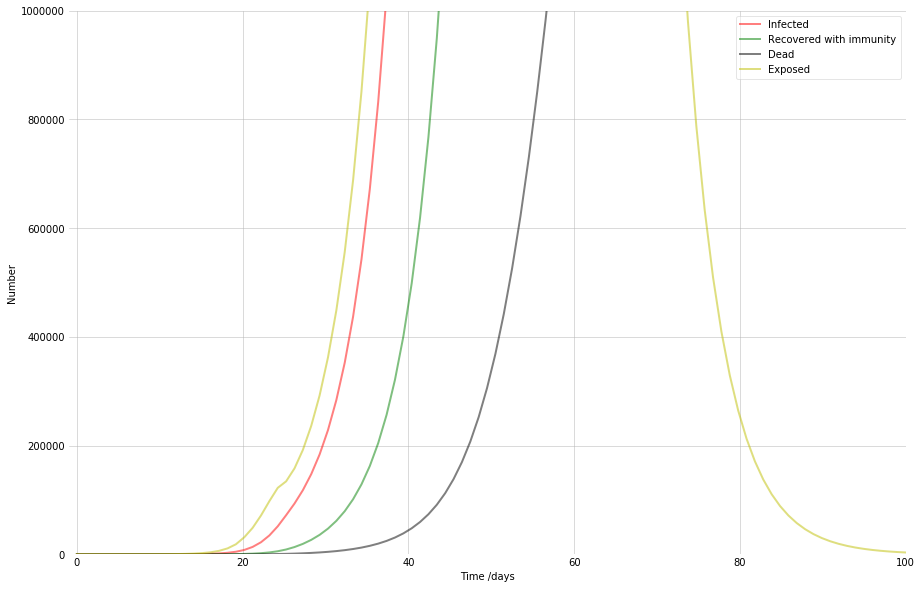

In [75]:
t = np.linspace(0, steps, steps)

# Figure
plt.rcParams['figure.figsize'] = (15,10) 
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='w', axisbelow=True)
# ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, D, 'k', alpha=0.5, lw=2, label='Dead')
ax.plot(t, E, 'y', alpha=0.5, lw=2, label='Exposed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(-0.01,1e6)
ax.set_xlim(-1,steps)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='#B6B6B6', lw=0.5, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
lectures[-1]

In [26]:
beta0 = 1.0
t = np.linspace(0, 150, 150)
y = np.array([beta(i) for i in t])

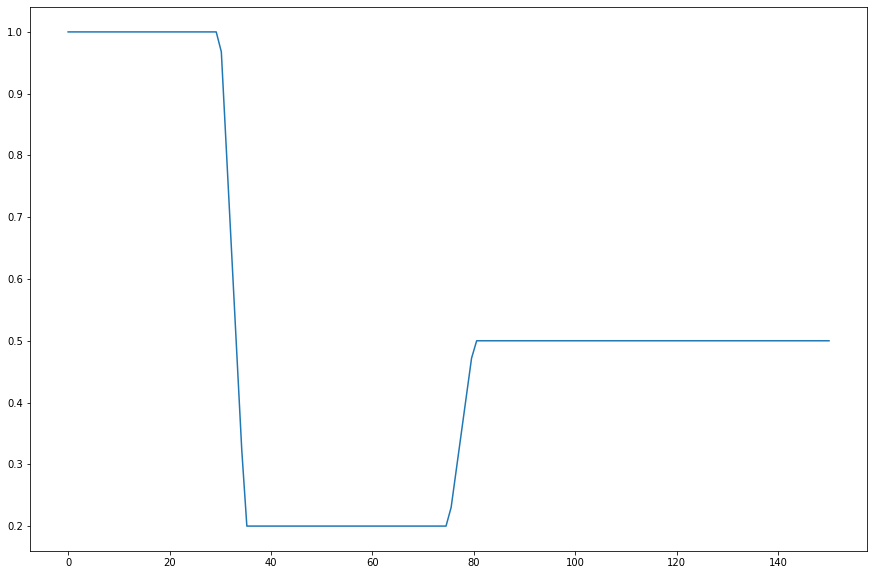

In [27]:
plt.plot(t,y)

## Plotting available data

In [ ]:
# evolution_video('../../data/clean\\EPI\\france_departments.csv', 'hosp', 'Hospitalizations')

In [ ]:
# evolution_video('../../data/clean\\EPI\\france_departments.csv', 'rea', 'Reanimations')

In [ ]:
# evolution_video('../../data/clean\\EPI\\france_departments.csv', 'dc', 'Deaths')